<a href="https://colab.research.google.com/github/doeungim/ADP_DE2/blob/main/%EB%AA%A8%EC%9D%981.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


In [35]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/ADP_SONY/ADP_SET_1/data/bitcoin_mock.csv')
df.head()

,datetime,open,high,low,close,volume
0,2022-01-01 00:00:00,46216.93,46271.08,46208.37,46250.00,40.57574
1,2022-01-01 00:01:00,46250.00,46344.23,46234.39,46312.76,42.38106
2,2022-01-01 00:02:00,46312.76,46381.69,46292.75,46368.73,51.29955
3,2022-01-01 00:03:00,46368.73,46391.49,46314.26,46331.08,30.45894
4,2022-01-01 00:04:00,46331.07,46336.10,46300.00,46321.34,20.96029


In [36]:
df['datetime'] = pd.to_datetime(df['datetime'])
df['datetime'].diff(1).dt.seconds.max()

# 데이터 생성
min, max = df['datetime'].min() , df['datetime'].max()
date_range = pd.DataFrame(pd.date_range(start = min, end = max, freq ='1T'), columns = ['new_date'])

m_df = pd.merge(df, date_range, how = 'right' , right_on = 'new_date', left_on = 'datetime')

# 보간법 결측처리
m_df = m_df.interpolate(method = 'linear')
m_df = m_df.drop(columns = ['datetime'], axis = 1)

In [37]:
# 전처리
# 1. 이동평균 t_5, t_120
m_df['t_5'] = m_df['close'].rolling(5).mean()
m_df['t_120'] = m_df['close'].rolling(120).mean()

# 2. t-1_5, t-1_120
m_df['t_1_5']= m_df['t_5'].shift(1)
m_df['t_1_120']= m_df['t_120'].shift(1)

In [38]:
pd.Series(
np.where(
    ((m_df['t_5'] > m_df['t_120']) & (m_df['t_1_5'] < m_df['t_1_120'])) , 'buy',
    np.where(
        ((m_df['t_5'] < m_df['t_120']) & (m_df['t_1_5'] > m_df['t_1_120'])) , 'sell', 'stay'
    ))).value_counts()

,count
stay,598515
sell,7319
buy,7319


In [39]:
def get_signal(row):
    if row['t_5'] > row['t_120'] and row['t_1_5'] < row['t_1_120']:
        return 'buy'
    elif row['t_5'] < row['t_120'] and row['t_1_5'] > row['t_1_120']:
        return 'sell'
    else:
        return 'stay'

# 각 행에 함수 적용
m_df['signal'] = m_df.apply(get_signal, axis=1)
m_df['signal'].value_counts()

,count
signal,
stay,598515
sell,7319
buy,7319


In [40]:
m_df['t_10'] = m_df['open'].shift(-10)

def result(x) :
  signal = x['signal']
  t10 = x['t_10']
  close = x['close']

  if signal == 'buy' :
    if t10 >= close :
      return 'buy'
    elif t10 < close :
      return 'loss'

  elif signal == 'sell' :
    if t10 >= close:
      return 'loss'
    elif t10 < close :
      return 'profit'

  elif signal =='stay' :
    return 'stay'

m_df['result'] = m_df.apply(result, axis = 1)
m_df['result'].value_counts()

,count
result,
stay,598515
loss,7549
buy,3563
profit,3526


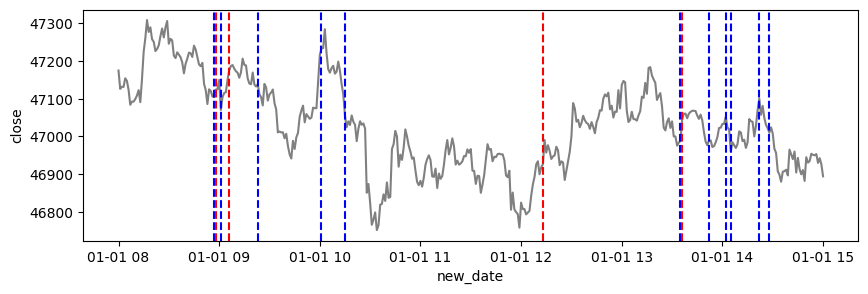

In [41]:
plot_df = m_df.dropna()

start = pd.to_datetime('2022-01-01 08:00:00 ')
end =  pd.to_datetime('2022-01-01 15:00:00')

p_df = m_df[(m_df['new_date'] >=start) & (m_df['new_date'] <= end)].reset_index(drop = True)

plt.figure(figsize = (10, 3))
sns.lineplot(x = 'new_date', y = 'close' , data = p_df, color = 'grey')

# Values로 뽑아서 [0,1]일때 뽑아오기
for data in p_df[p_df['signal'] != 'stay'][['new_date','result']].values :
  time = data[0]
  signal = data[1]

  if signal == 'buy' :
    plt.axvline(time, color = 'r' , label = 'buy' ,linestyle ='--')
  else :
    plt.axvline(time, color = 'b', label = 'sell', linestyle = '--')

plt.show()

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler

r_df = m_df.dropna().reset_index(drop = True)

#1) 컬럼 생성
r_df['del_oc'] = r_df['open'] - r_df['close']
r_df['del_5min'] = r_df['close'] - r_df['close'].shift(5)

#2022년 2월 ~ 12월까지의 데이터를 train, 2023년 1~2월의 데이터를 평가 데이터로 하고
#result의 값이 loss,profit인 데이터만 학습에 사용하여

f_df = r_df[r_df['result'].isin(['loss','profit'])]
model_df = f_df[['new_date','open','del_oc','del_5min','signal','result']]

train = model_df[(model_df['new_date'].dt.year == 2022) & (model_df['new_date'].dt.month.isin(range(2,13)))]
test = model_df[(model_df['new_date'].dt.year == 2023) & (model_df['new_date'].dt.month.isin(range(1,3)))]

x_train = train.drop(columns = ['new_date' , 'result'], axis = 1)
y_train = train['result']

x_test = test.drop(columns = ['new_date' , 'result'], axis = 1)
y_test = test['result']

def clean_df(x) :
  for col in x.columns :
    if x[col].dtype != 'object' :
       x[col] = StandardScaler().fit_transform(x[[col]]).flatten()
    else :
      dummies = pd.get_dummies(x[col], prefix = col, dtype = int)
      for d_col in dummies.columns :
        x[d_col] = dummies[d_col]
      x = x.drop(columns = col, axis = 1)

  return x

x_train_clean = clean_df(x_train).reset_index()
x_test_clean = clean_df(x_test).reset_index()


def eval(name, model) :
  model.fit(x_train_clean, y_train)

  pred = model.predict(x_test_clean)

  pred_proba = model.predict_proba(x_test_clean)
  porfit_index = model.classes_.tolist().index('profit')
  pred_p = ['profit' if p[porfit_index] >= 0.6 else 'loss' for p in pred_proba]


  acc = accuracy_score(y_test, pred)
  f1 = f1_score(y_test, pred,  pos_label='profit')
  return name, acc, f1

res =[]
for name, model in [['RF', RandomForestClassifier()] , ['SVC', SVC(probability= True)]] :
  name, acc, f1 = eval(name, model)
  res.append([name, acc, f1])

pd.DataFrame(res)

,0,1,2
0,RF,0.658397,0.539056
1,SVC,0.696565,0.000000


#### 문제 2) 유저 카드데이터

In [43]:
df = pd.read_csv('/content/drive/MyDrive/ADP_SONY/ADP_SET_1/data/user_data.csv')
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [44]:
# 1. 결측치
display(df.isna().sum().to_frame().T)

# 2. 결측처리
# MINUMUM_PAYMENTS 결측처리
df['MINIMUM_PAYMENTS']= np.where(
                                (pd.isna(df['MINIMUM_PAYMENTS']) & (df['MINIMUM_PAYMENTS'] == 0)) , 0 ,
                                np.where(
                                    (pd.isna(df['MINIMUM_PAYMENTS']) & (df['MINIMUM_PAYMENTS'] > 0)) , df['MINIMUM_PAYMENTS'].mean() , df['MINIMUM_PAYMENTS']
                                )
                            )

df['CREDIT_LIMIT'] = df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].mean())

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,313,0,0


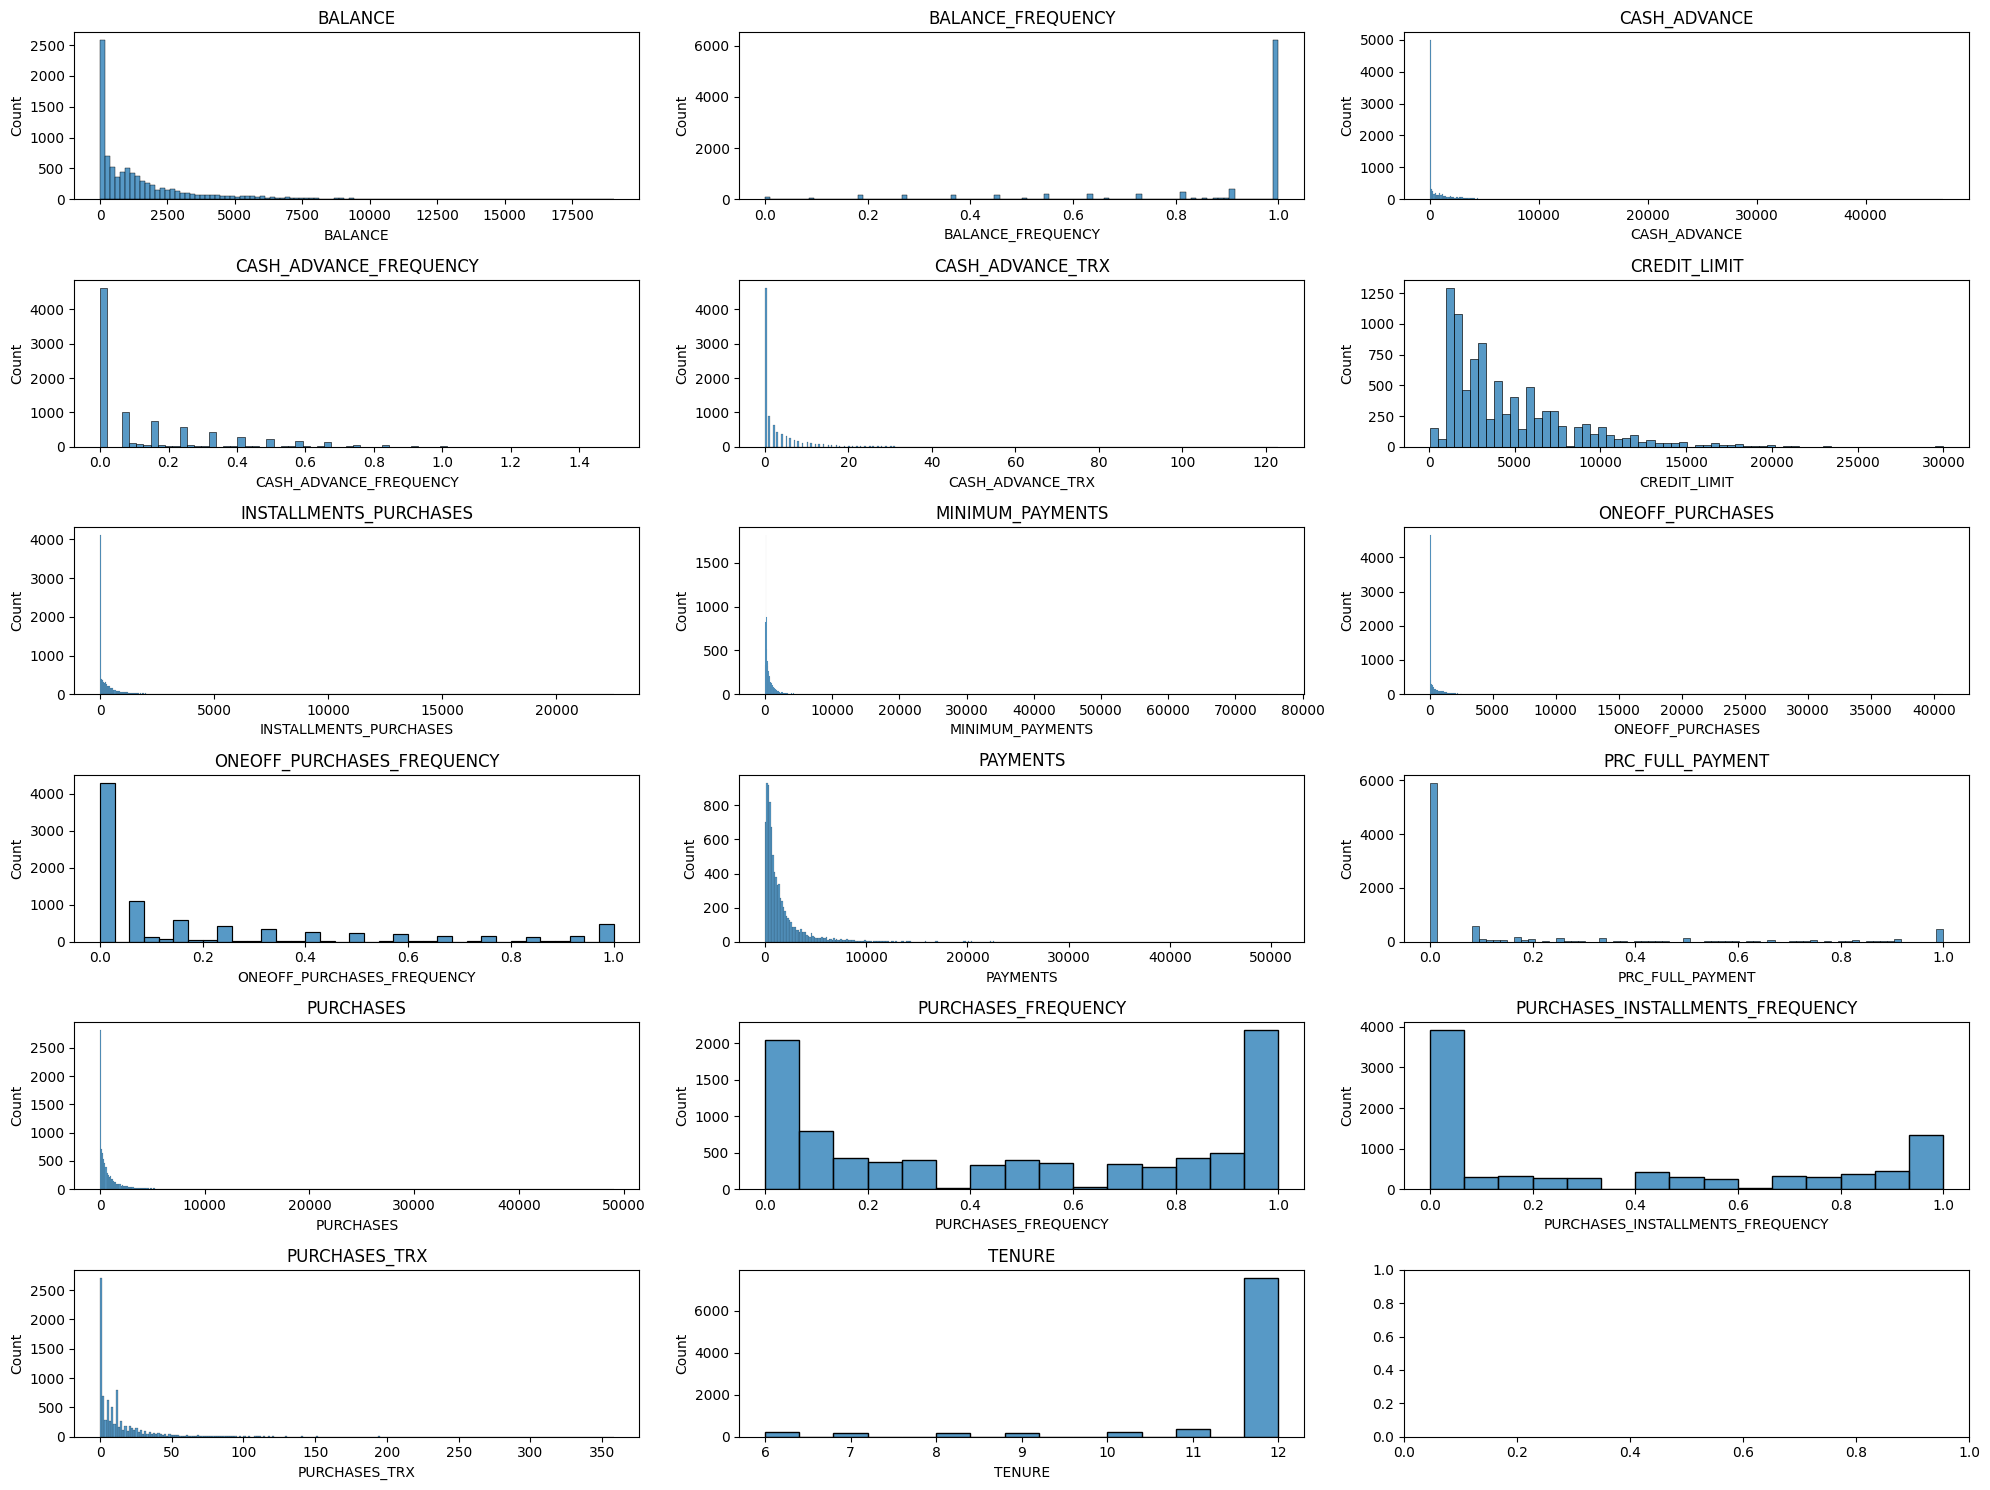

In [45]:
# EDA

fig, axes = plt.subplots(6,3, figsize = (20, 15))

for axes, col in zip(axes.flatten(), df.columns.difference(['CUST_ID'])) :
  sns.histplot(df[col], ax = axes)
  axes.set_title(col)

plt.tight_layout()
plt.show()

<Axes: >

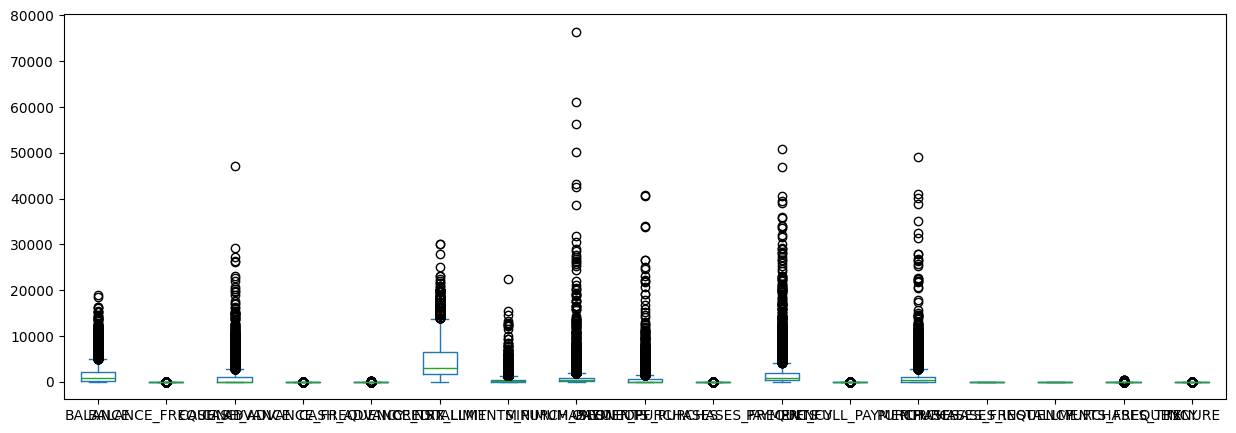

In [46]:
fig, ax = plt.subplots(figsize = (15,5))
df[df.columns.difference(['CUST_ID'])].plot(kind = 'box', ax = ax)

In [47]:
# 이상치 제거하기
def remove_iqr(df) :
  iqr_df = df.copy() # Create a copy to avoid modifying the original DataFrame
  for col in df.columns :
    if df[col].dtype != 'object': # Only apply to numeric columns
      q1 = iqr_df[col].quantile(0.25)
      q3 = iqr_df[col].quantile(0.75) # Fixed typo here

      iqr = q3 - q1

      lower = q1 - iqr * 1.5
      upper = q3 + iqr * 1.5

      iqr_df = iqr_df[(iqr_df[col] >= lower) | (iqr_df[col] <= upper)].reset_index(drop = True)
  return iqr_df


df2 = remove_iqr(df)

#### PCA를 통해 적절한 차원으로 데이터를 축소하고 평가

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15,PC_16,PC_17
Ratio,0.474932,0.178142,0.140172,0.114685,0.047237,0.026594,0.018230,0.000007,7.323091e-07,5.917558e-07,3.621778e-08,4.089731e-09,1.459813e-09,1.403887e-09,7.270651e-10,2.585131e-10,1.516347e-10
cumsum,0.474932,0.653074,0.793246,0.907930,0.955167,0.981762,0.999992,0.999999,9.999994e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


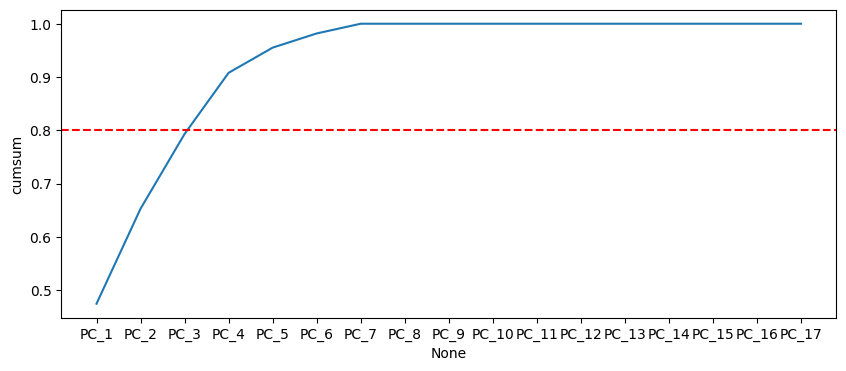

In [73]:
from sklearn.decomposition import PCA

pca_x = df2.drop(columns = 'CUST_ID', axis = 1)

ss = StandardScaler()
scaled_pca_x = ss.fit_transform(pca_x)
scaled_pca_x = pd.DataFrame(scaled_pca_x , columns = pca_x.columns)


pca = PCA()
p = pca.fit(pca_x)

pca_df = pd.DataFrame({
    'Ratio' : p.explained_variance_ratio_,
    'cumsum' : p.explained_variance_ratio_.cumsum()
})

pca_df.index = ['PC_' + str(x+1) for x in range(len(pca_df.index))]
display(pca_df.T)

plt.figure(figsize = (10, 4))
sns.lineplot(x = pca_df.index, y = pca_df['cumsum'], data = pca_df)
plt.axhline(0.8, color = 'red', linestyle = '--')

차원 축소된 데이터를 바탕으로 KMeans 클러스터링을 실시하라. </br>
응집도와 분리도를 기반으로 적절 클러스터 숫자를 구하고 두개의 주성분 차원에 군집 중심을 포함하여 시각화

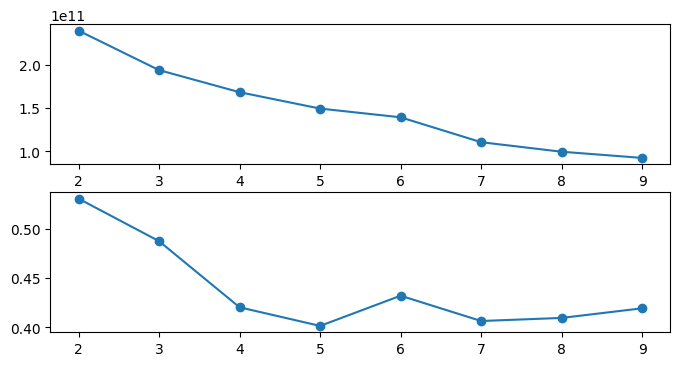

In [85]:
pca_x = df2.drop(columns = 'CUST_ID', axis = 1)

ss = StandardScaler()
scaled_pca_x = ss.fit_transform(pca_x)
scaled_pca_x = pd.DataFrame(scaled_pca_x , columns = pca_x.columns)


pca = PCA(n_components = 4)
pc_x = pd.DataFrame(pca.fit_transform(pca_x))

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

res = []
sil = []
for i in range(2, 10):
  km = KMeans(n_clusters = i)
  km.fit(pc_x)
  label = km.predict(pc_x)
  res.append(km.inertia_)
  sil.append(silhouette_score(pc_x, km.labels_))

fig, axes = plt.subplots(2,1, figsize = (8, 4))
axes[0].plot(range(2,10), res, marker = 'o')
axes[1].plot(range(2,10), sil, marker = 'o')

KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=9), k=(1, 10))

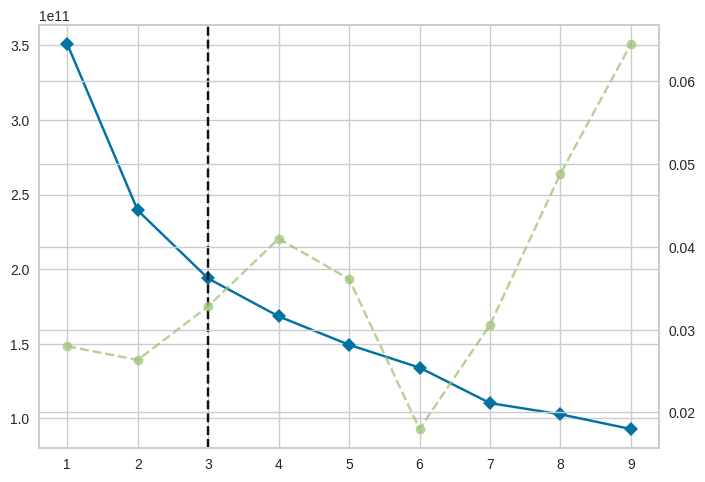

In [88]:
from yellowbrick.cluster import KElbowVisualizer
km = KMeans()
plot = KElbowVisualizer(km, k = (1, 10))
plot.fit(pc_x)

어느 자동차 회사의 본사에서 여러 지방 영업소에 내려보낸 43대의 새 차 중 11대에 불량 오디오가 설치되었다고 한다. 어느 영업소가 8대를 인수하였는데 이 중에서 오디오가 불량인 차가 적어도 2대 이상이 될 확률

In [89]:
from scipy.stats import hypergeom

rv = hypergeom(43, 11,8)
1 - rv.cdf(1)

np.float64(0.6721384488647228)

1. 변수들의 다중공선성을 검토하라
2. 다중공선성 문제를 해결하기 위한 방법 2가지를 제시하고, 하나를 선택하여 적용
3. 2-2의 방법을 전,후의 회귀 분석 모델의 결과를 비교

In [91]:
df = pd.read_csv('/content/drive/MyDrive/ADP_SONY/ADP_SET_1/data/stats_reg1.csv')
df.head()
target = df.drop(columns = 'Target', axis = 1)
target.head(5)

,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,F_10,F_11,F_12,F_13,F_14,F_15
0,0.296120,-1.463515,-0.327662,0.005113,-0.702053,0.097078,-0.392108,0.261055,0.968645,2,3,1.475520,-0.363724,-0.503583,-1.464364
1,1.579213,-0.234137,1.523030,-0.469474,0.647689,0.496714,-0.234153,0.767435,-0.138264,2,1,0.387250,0.907459,0.928492,0.938609
2,-0.562467,0.707752,-0.626967,0.972554,1.770801,-0.703176,1.812449,0.632408,-0.034988,2,2,0.955285,-0.096463,-0.030130,2.166524
3,1.496044,-1.778720,-0.773789,-0.055585,1.876796,1.355638,-1.244655,0.654366,0.413435,2,1,0.441394,0.352448,-0.467829,2.433214
4,-0.759133,-0.525755,-0.599393,0.341756,-0.839722,2.189803,-2.123896,0.150394,-0.808298,1,2,0.991974,-0.562178,-0.176573,-0.068282


In [98]:
# 1. 다중공선성 검토하기
# 1.1 상관분석
cor_df = target.corr(method = 'spearman').unstack().reset_index()
cor_df.columns= ['col1','col2', 'corr']

cor_df[(cor_df['col1'] != cor_df['col2']) & (cor_df['corr'].abs() >= 0.7)]

# F1, F11삭제 후 VIF 진행

,col1,col2,corr
12,F_1,F_13,0.820678
161,F_11,F_12,0.914595
175,F_12,F_11,0.914595
180,F_13,F_1,0.820678


In [101]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
df2 = target.drop(columns = ['F_1','F_11'] , axis =1)

v_df = pd.DataFrame()
v_df['col'] = df2.columns
v_df['v'] = [variance_inflation_factor(df2.values, i) for i in range(df2.shape[1])]
v_df

,col,v
0,F_2,1.270203
1,F_3,1.975258
2,F_4,1.774063
3,F_5,2.181707
4,F_6,1.089507
5,F_7,1.165103
6,F_8,1.082959
7,F_9,1.173637
8,F_10,5.711413
9,F_12,5.718716


In [107]:
# 회귀분석모델 적용
import statsmodels.api as sm

# 1) 공선성 제거전
before_X = df.drop(columns = 'Target', axis = 1)
after_X = df.drop(columns = ['Target' ,'F_1','F_11'], axis = 1)
y = df['Target']

add_x = sm.add_constant(before_X)
before = sm.OLS(y , before_X).fit()


add_x = sm.add_constant(after_X)
after = sm.OLS(y , after_X).fit()

print(before.summary().tables[1])
print(after.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
F_1           61.6580      0.063    974.851      0.000      61.532      61.784
F_2           28.6890      0.034    836.858      0.000      28.621      28.757
F_3           50.7616      0.015   3423.197      0.000      50.732      50.791
F_4           63.1700      0.013   5051.162      0.000      63.145      63.195
F_5           83.1976      0.012   7212.397      0.000      83.175      83.221
F_6           16.0574      0.011   1491.755      0.000      16.036      16.079
F_7            0.6324      0.010     65.416      0.000       0.613       0.652
F_8           98.1082      0.010   9934.706      0.000      98.089      98.128
F_9           81.7984      0.009   8972.607      0.000      81.780      81.816
F_10           0.0083      0.010      0.790      0.432      -0.013       0.029
F_11           0.0003      0.047      0.006      0.9

In [108]:
df = pd.read_csv('/content/drive/MyDrive/ADP_SONY/ADP_SET_1/data/learn.csv')
df.head()

,Student,Lecture,Online,Blended
0,1,8.7,67.8,74.2
1,2,18.2,97.2,76.5
2,3,7.5,74.8,69.1
3,4,39.7,62.3,68.4
4,5,73.4,84.9,84.5


In [122]:
# 학생당, Lecture, Online, Blended으 성적 즉, 같은 사람에게 세 방식이 반복적용
# 일원분산분석
#!pip install scikit_posthocs
from scipy.stats import shapiro, friedmanchisquare
import scikit_posthocs as sp
# 1.정규성 검증
res  = []
for col in df.drop(columns = 'Student', axis = 1).columns :
  stat, p_val = shapiro(df[col])
  decision = '정규분포이다' if p_val > 0.05 else '정규분포가 아니다'
  res.append({
      'Columns' : col,
      'P_value' : p_val,
      'Decision' : decision
  })
display(pd.DataFrame(res))

stat, p = friedmanchisquare(df['Lecture'], df['Online'], df['Blended'])
print(f"\nFriedman Test p-value: {p:.4f}")


# 사후검정 dunn - pivoting으로 변환 후
df_melt = df.melt(id_vars='Student', value_vars=['Lecture', 'Online', 'Blended'],
                  var_name='Method', value_name='Score')
dunn = sp.posthoc_dunn(df_melt, val_col = 'Score', group_col = 'Method' , p_adjust= 'bonferroni')
display(dunn)

,Columns,P_value,Decision
0,Lecture,0.004650,정규분포가 아니다
1,Online,0.909854,정규분포이다
2,Blended,0.363978,정규분포이다



Friedman Test p-value: 0.0000


,Blended,Lecture,Online
Blended,1.000000e+00,1.595849e-09,0.695187
Lecture,1.595849e-09,1.000000e+00,0.000002
Online,6.951872e-01,1.603791e-06,1.000000
